In [8]:
# Import Packages
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv("./mbti_cleaned.csv")

#### N-gram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

def get_ngram_freq_vector(texts, vocab=None, ngram_range=(3,3)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', vocabulary=vocab)
    X = vectorizer.fit_transform(texts) if vocab is None else vectorizer.transform(texts)
    freqs = np.asarray(X.sum(axis=0)).flatten() + 1  # Add-1 smoothing
    probs = freqs / freqs.sum()
    return probs, vectorizer.get_feature_names_out()

def kl_divergence(p, q):
    return np.sum(rel_entr(p, q))

def js_divergence(p, q):
    return jensenshannon(p, q, base=2) ** 2

In [31]:
trait_map = {
    'I/E': {True: 'I', False: 'E'},
    'S/N': {True: 'S', False: 'N'},
    'T/F': {True: 'T', False: 'F'},
    'P/J': {True: 'P', False: 'J'}
}

# Collect texts per individual trait
trait_texts = {}
for label, mapping in trait_map.items():
    for bool_val, trait in mapping.items():
        trait_texts[trait] = data[data[label] == bool_val]['cleaned_posts'].tolist()

all_texts = sum(trait_texts.values(), [])

In [32]:
def analysis_n_gram(n = 2):
    if n == 2:
        gram = "Bi"
    elif n ==3:
        gram = "Tri"
    else:
        gram = f"{n}-"
    
    _, joint_vocab = get_ngram_freq_vector(all_texts, ngram_range=(n,n))

    # n-gram probability vectors for each trait
    trait_probs = {
        trait: get_ngram_freq_vector(trait_texts[trait], vocab=joint_vocab, ngram_range=(n,n))[0]
        for trait in trait_texts
    }

    traits = list(trait_probs.keys())
    kl_matrix = pd.DataFrame(index=traits, columns=traits)
    js_matrix = pd.DataFrame(index=traits, columns=traits)

    for t1 in traits:
        for t2 in traits:
            kl_matrix.loc[t1, t2] = kl_divergence(trait_probs[t1], trait_probs[t2])
            js_matrix.loc[t1, t2] = js_divergence(trait_probs[t1], trait_probs[t2])

    plt.figure(figsize=(8, 6))
    sns.heatmap(kl_matrix.astype(float), annot=True, cmap='YlOrRd', fmt=".3f")
    plt.title(f"KL Divergence Between MBTI Traits ({gram}gram Distributions)")
    plt.xlabel("To")
    plt.ylabel("From")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(js_matrix.astype(float), annot=True, cmap='YlGnBu', fmt=".3f")
    plt.title(f"Jensen-Shannon Divergence Between MBTI Traits ({gram}gram Distributions)")
    plt.xlabel("To")
    plt.ylabel("From")
    plt.tight_layout()
    plt.show()


    # Convert JS divergence matrix to condensed distance matrix
    dist_array = squareform(js_matrix.astype(float))  # symmetric matrix to condensed form
    linkage_matrix = linkage(dist_array, method='average')  # or 'ward', 'complete'

    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=js_matrix.index, leaf_rotation=0)
    plt.title("Hierarchical Clustering of MBTI Traits (JS Divergence)")
    plt.ylabel("Jensen-Shannon Distance")
    plt.show()


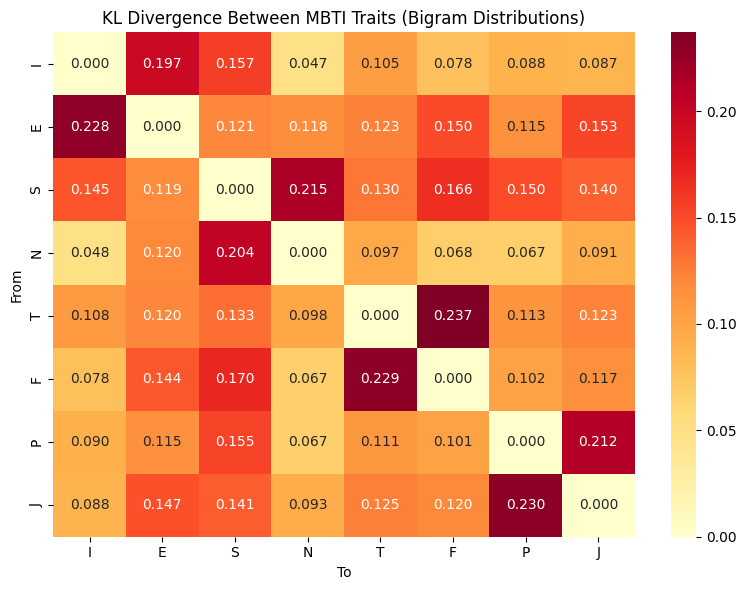

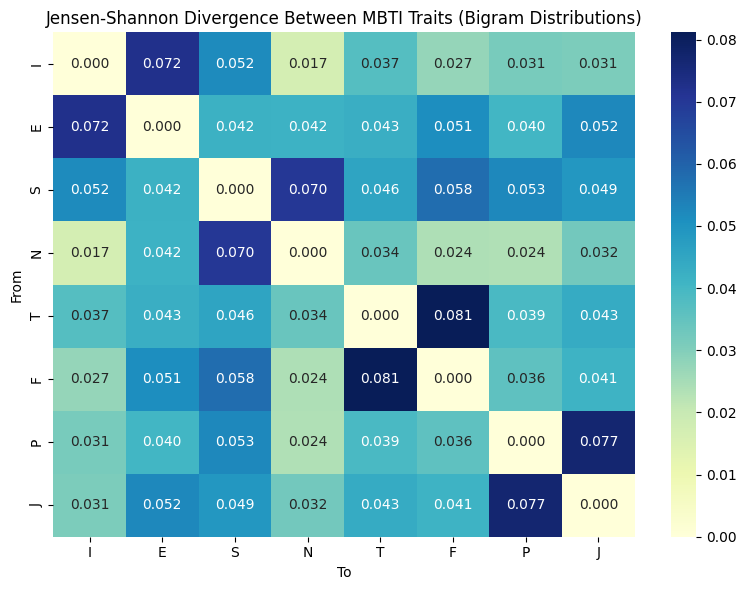

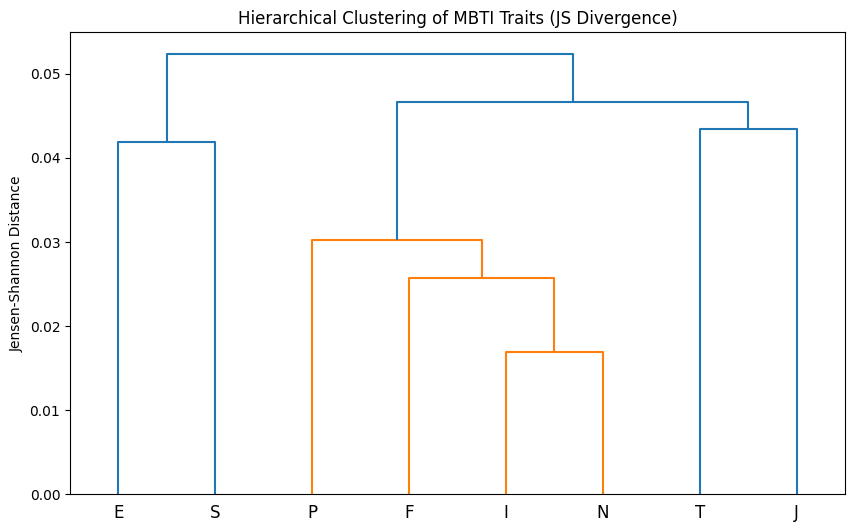

In [33]:
analysis_n_gram(2)

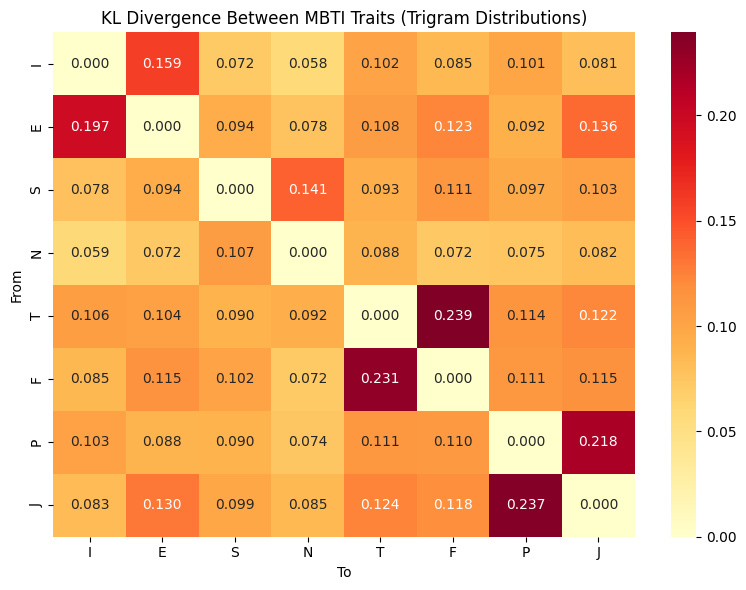

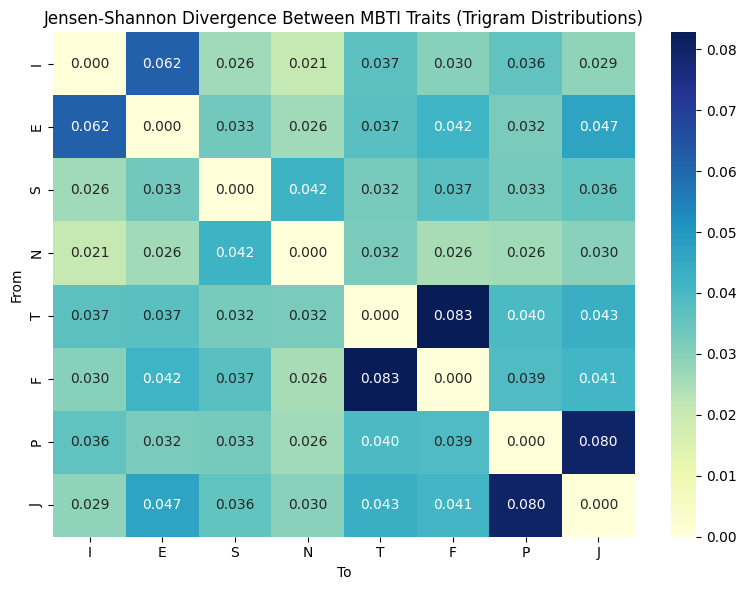

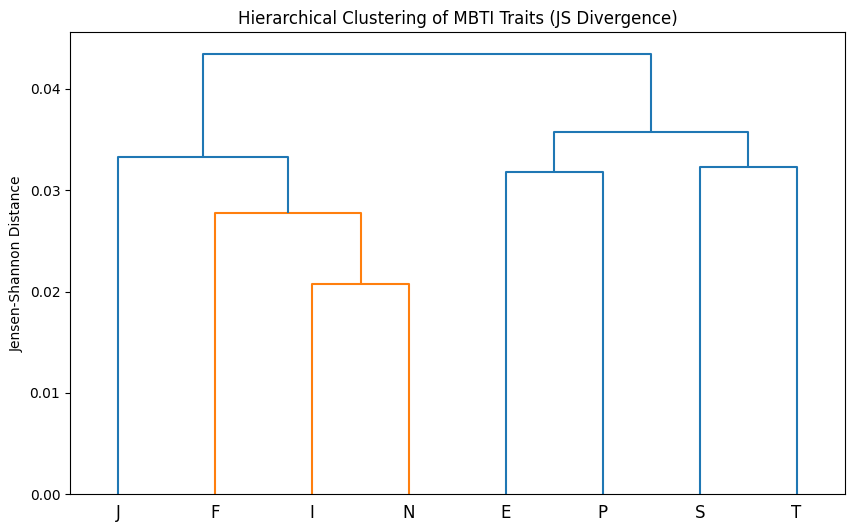

In [34]:
analysis_n_gram(3)

#### TSNE

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(data['cleaned_posts'].tolist(), show_progress_bar=True)

data['I/E'] = data['I/E'].map({True: 'I', False: 'E'})
data['S/N'] = data['S/N'].map({True: 'S', False: 'N'})
data['T/F'] = data['T/F'].map({True: 'T', False: 'F'})
data['P/J'] = data['P/J'].map({True: 'P', False: 'J'})

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_embeddings)

# Step 3: t-SNE Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# Step 4: Plotting
data['tsne_1'] = X_tsne[:, 0]
data['tsne_2'] = X_tsne[:, 1]


Batches:   0%|          | 0/272 [00:00<?, ?it/s]

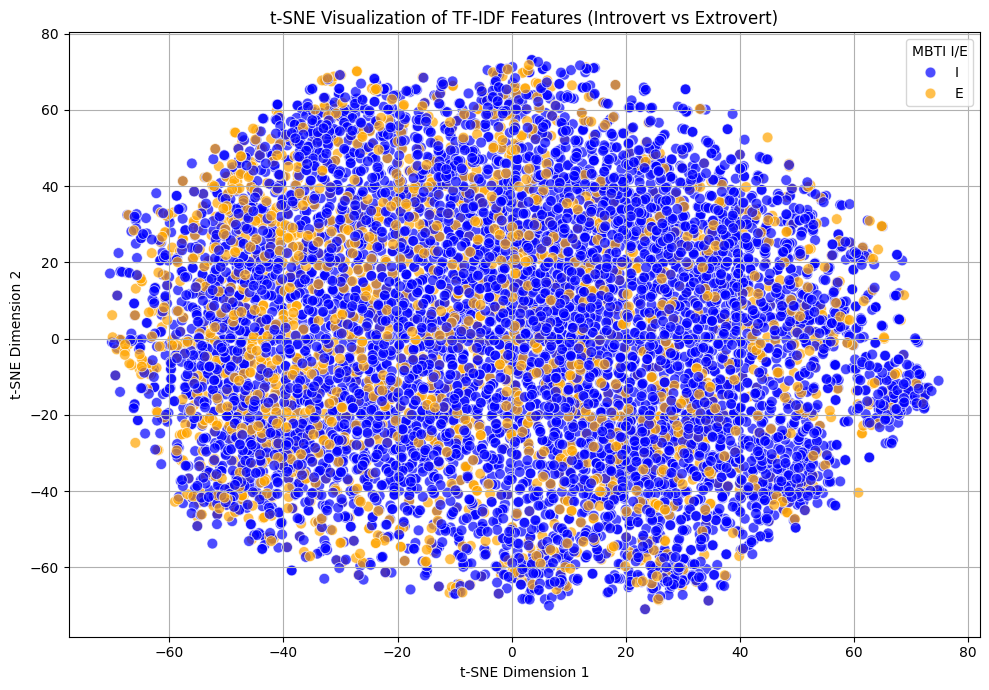

In [12]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='I/E',
    data=data,
    palette={'I': 'blue', 'E': 'orange'},
    alpha=0.7,
    s=60
)
plt.title("t-SNE Visualization of TF-IDF Features (Introvert vs Extrovert)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='MBTI I/E')
plt.grid(True)
plt.tight_layout()
plt.show()

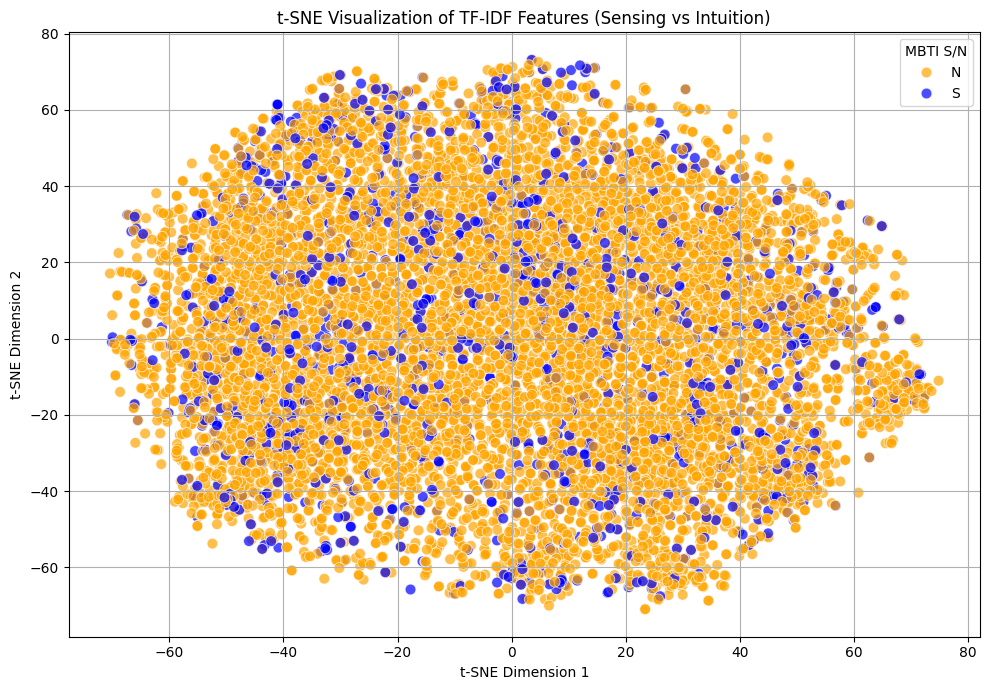

In [13]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='S/N',
    data=data,
    palette={'S': 'blue', 'N': 'orange'},
    alpha=0.7,
    s=60
)
plt.title("t-SNE Visualization of TF-IDF Features (Sensing vs Intuition)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='MBTI S/N')
plt.grid(True)
plt.tight_layout()
plt.show()

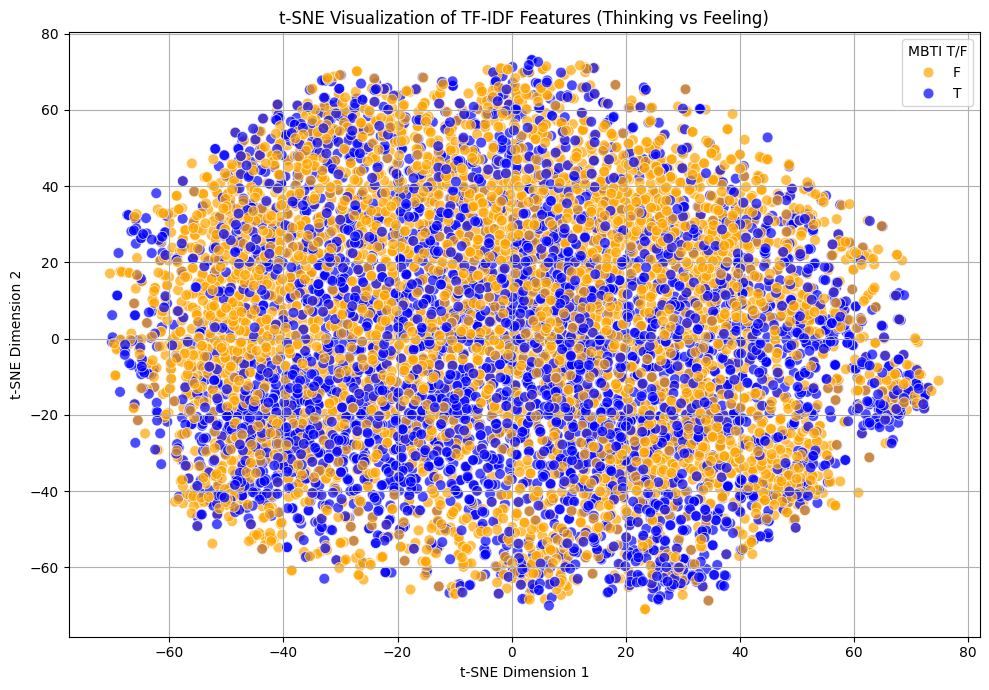

In [14]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='T/F',
    data=data,
    palette={'T': 'blue', 'F': 'orange'},
    alpha=0.7,
    s=60
)
plt.title("t-SNE Visualization of TF-IDF Features (Thinking vs Feeling)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='MBTI T/F')
plt.grid(True)
plt.tight_layout()
plt.show()

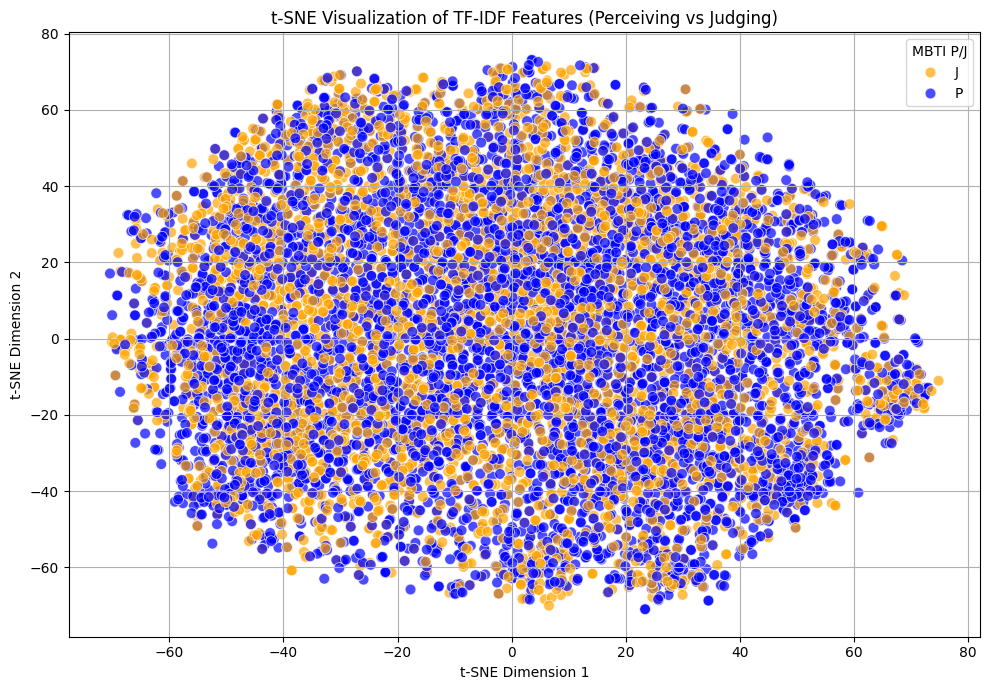

In [15]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='P/J',
    data=data,
    palette={'P': 'blue', 'J': 'orange'},
    alpha=0.7,
    s=60
)
plt.title("t-SNE Visualization of TF-IDF Features (Perceiving vs Judging)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='MBTI P/J')
plt.grid(True)
plt.tight_layout()
plt.show()